In [1]:
import json
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from fpdf import FPDF

src_path = Path('./src')
if str(src_path.resolve()) not in sys.path:
    sys.path.append(str(src_path.resolve()))

import beta_engine
from state import State
from climber_model import ClimberModel
from visualizer import calculate_full_body_pose

# --- Constants ---
# Make sure this image exists
IMAGE_PATH = Path('sample_route.jpg')
# --- DYNAMICALLY GET IMAGE SIZE ---
# Use Pillow to open the image and get its actual dimensions
try:
    with Image.open(IMAGE_PATH) as img:
        IMAGE_WIDTH, IMAGE_HEIGHT = img.size
    print(f"Image loaded successfully: {IMAGE_WIDTH}px width, {IMAGE_HEIGHT}px height")
except FileNotFoundError:
    print(f"ERROR: Image not found at {IMAGE_PATH}")
    # Assign default values or stop execution if the image is essential
    IMAGE_WIDTH, IMAGE_HEIGHT = 800, 1000
# ------------------------------------

ROUTE_DATA_PATH = src_path / "route_data.json"

Image loaded successfully: 1170px width, 2532px height


In [2]:
import os
print(os.getcwd())


D:\FermataBeta\backend\beta_generator


In [3]:
# --- 1. Load Route Data ---
with open(ROUTE_DATA_PATH, "r") as f:
    route_data = json.load(f)

# --- 2. Initialize Models ---
climber = ClimberModel()
climber.scale_to_image(IMAGE_HEIGHT)

scaled_hold_coords = {
    h['id']: (h['xNorm'] * IMAGE_WIDTH, h['yNorm'] * IMAGE_HEIGHT)
    for h in route_data['holds']
}

# --- 3. Configure Beta Engine ---
beta_engine.climber = climber
beta_engine.holds_data = route_data['holds']
beta_engine.hold_coords = scaled_hold_coords
beta_engine.finish_id = route_data['finish']

# --- 4. Define Start State and Run Search ---
start_holds = route_data['start']
start_state = State(
    RH=start_holds.get('RH'), LH=start_holds.get('LH'),
    RF=start_holds.get('RF'), LF=start_holds.get('LF')
)

beta_sequence = beta_engine.a_star_search(start_state)

# --- 5. Print Results ---
if beta_sequence:
    print(f"✅ SUCCESS: Path found in {len(beta_sequence) - 1} moves.")
    # This is the data structure your frontend will eventually receive
    print(beta_sequence)
else:
    print("❌ FAILURE: No feasible path was found.")

Starting A* Search...
  ... expanded 500 states. Frontier size: 1658
  ... expanded 1000 states. Frontier size: 2693
  ... expanded 1500 states. Frontier size: 3230
  ... expanded 2000 states. Frontier size: 3623
  ... expanded 2500 states. Frontier size: 4109
  ... expanded 3000 states. Frontier size: 4461
  ... expanded 3500 states. Frontier size: 4632
  ... expanded 4000 states. Frontier size: 4853
  ... expanded 4500 states. Frontier size: 5066
  ... expanded 5000 states. Frontier size: 5184
  ... expanded 5500 states. Frontier size: 5232
  ... expanded 6000 states. Frontier size: 5391
  ... expanded 6500 states. Frontier size: 5622
  ... expanded 7000 states. Frontier size: 5738
  ... expanded 7500 states. Frontier size: 6001
  ... expanded 8000 states. Frontier size: 6152
  ... expanded 8500 states. Frontier size: 6208
  ... expanded 9000 states. Frontier size: 6303
  ... expanded 9500 states. Frontier size: 6319
  ... expanded 10000 states. Frontier size: 6383
  ... expanded 105

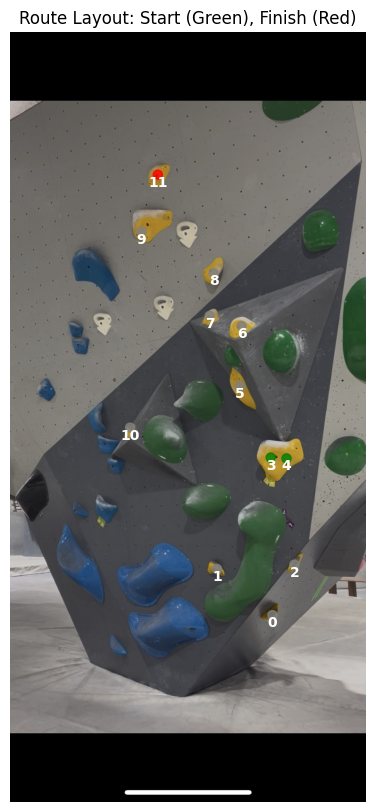

In [4]:
# Cell for visualizing the route layout
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
img = Image.open(IMAGE_PATH)
fig, ax = plt.subplots(1, figsize=(8, 10))
ax.imshow(img)

# Plot all holds
for hold in route_data['holds']:
    x = hold['xNorm'] * IMAGE_WIDTH
    y = hold['yNorm'] * IMAGE_HEIGHT
    
    # Determine color and label
    color = 'grey'
    if hold['id'] in [3, 4]: # Start holds
        color = 'green'
    elif hold['id'] == 11: # Finish hold
        color = 'red'
        
    # Draw circle and ID text
    ax.add_patch(plt.Circle((x, y), 15, color=color, alpha=0.8, zorder=5))
    ax.text(x, y + 25, str(hold['id']), color='white', ha='center', va='center', weight='bold', zorder=6)

plt.title("Route Layout: Start (Green), Finish (Red)")
plt.axis('off')
plt.show()

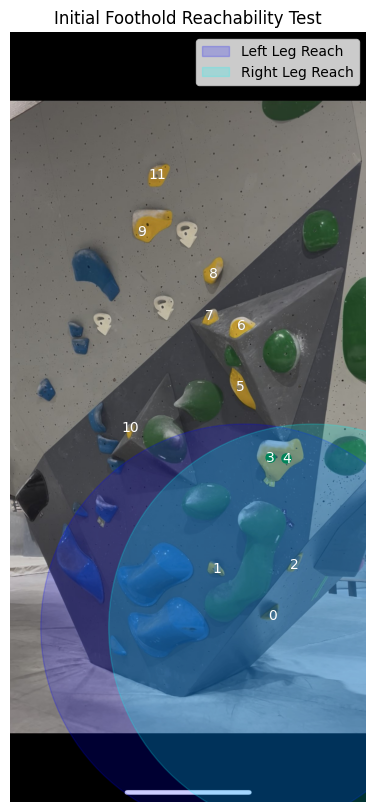

Checking for reachable footholds from the start:
  - Hold 0 IS reachable.
  - Hold 1 IS reachable.
  - Hold 2 IS reachable.
  - Hold 3 IS reachable.
  - Hold 4 IS reachable.


In [5]:
# Cell for checking initial foothold reachability
import math

# Get the pixel coordinates of the starting hand holds
start_hands = {
    'RH': (route_data['holds'][4]['xNorm'] * IMAGE_WIDTH, route_data['holds'][4]['yNorm'] * IMAGE_HEIGHT),
    'LH': (route_data['holds'][3]['xNorm'] * IMAGE_WIDTH, route_data['holds'][3]['yNorm'] * IMAGE_HEIGHT)
}

# --- Simulate the core position and hip locations ---
# This logic should mirror your visualizer/beta_engine's assumptions
avg_x = (start_hands['RH'][0] + start_hands['LH'][0]) / 2
avg_y = (start_hands['RH'][1] + start_hands['LH'][1]) / 2
core_y = avg_y + climber.torso_height / 2 # Core is below hands when hanging
hip_l_pos = (avg_x - climber.torso_width / 2, core_y + climber.torso_height)
hip_r_pos = (avg_x + climber.torso_width / 2, core_y + climber.torso_height)

# --- Visualize the reach ---
img = Image.open(IMAGE_PATH)
fig, ax = plt.subplots(1, figsize=(8, 10))
ax.imshow(img)

# Draw all holds
for hold in route_data['holds']:
    x = hold['xNorm'] * IMAGE_WIDTH
    y = hold['yNorm'] * IMAGE_HEIGHT
    ax.add_patch(plt.Circle((x, y), 10, color='grey', alpha=0.5))
    ax.text(x, y, str(hold['id']), color='white', ha='center', va='center')

# Draw starting hand holds
ax.add_patch(plt.Circle(start_hands['RH'], 15, color='green'))
ax.add_patch(plt.Circle(start_hands['LH'], 15, color='green'))

# Draw the climber's leg reach radius from the hips
leg_reach = climber.thigh_length + climber.shin_length
ax.add_patch(plt.Circle(hip_l_pos, leg_reach, color='blue', alpha=0.2, label='Left Leg Reach'))
ax.add_patch(plt.Circle(hip_r_pos, leg_reach, color='cyan', alpha=0.2, label='Right Leg Reach'))

plt.title("Initial Foothold Reachability Test")
plt.legend()
plt.axis('off')
plt.show()

# --- Print out reachable holds ---
print("Checking for reachable footholds from the start:")
found_foothold = False
for hold in route_data['holds']:
    h_pos = (hold['xNorm'] * IMAGE_WIDTH, hold['yNorm'] * IMAGE_HEIGHT)
    
    dist_to_l_hip = math.hypot(h_pos[0] - hip_l_pos[0], h_pos[1] - hip_l_pos[1])
    dist_to_r_hip = math.hypot(h_pos[0] - hip_r_pos[0], h_pos[1] - hip_r_pos[1])
    
    if dist_to_l_hip <= leg_reach or dist_to_r_hip <= leg_reach:
        print(f"  - Hold {hold['id']} IS reachable.")
        found_foothold = True

if not found_foothold:
    print("\n❌ CRITICAL FAILURE: No footholds are reachable from the starting hand positions.")
    print("This is likely why the algorithm is failing.")

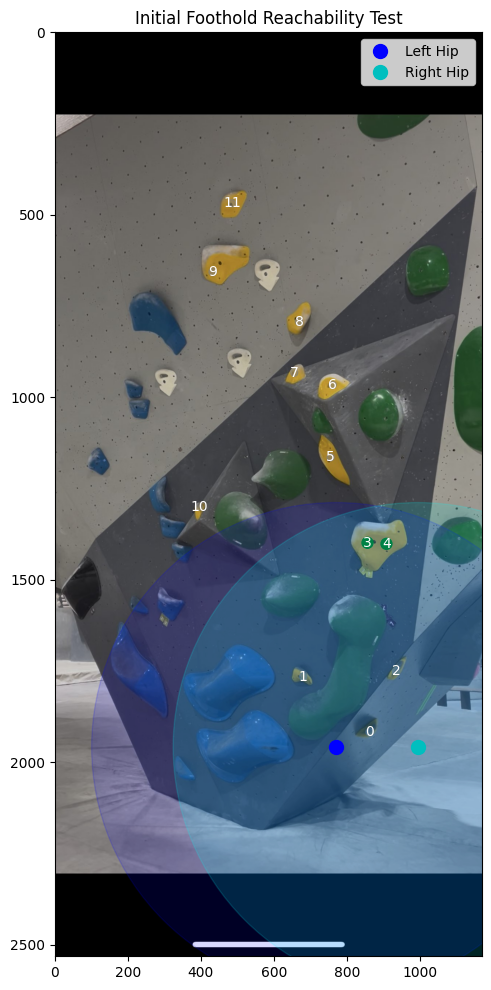

Checking for reachable footholds from the start:
  - Hold 0 IS reachable by the left foot.
  - Hold 0 IS reachable by the right foot.
  - Hold 1 IS reachable by the left foot.
  - Hold 1 IS reachable by the right foot.
  - Hold 2 IS reachable by the left foot.
  - Hold 2 IS reachable by the right foot.
  - Hold 3 IS reachable by the left foot.
  - Hold 3 IS reachable by the right foot.
  - Hold 4 IS reachable by the left foot.
  - Hold 4 IS reachable by the right foot.


In [6]:
# Cell to re-run the initial foothold reachability test
import math

# Get the pixel coordinates of the starting hand holds from your new route_data.json
start_hands = {
    'RH': (route_data['holds'][4]['xNorm'] * IMAGE_WIDTH, route_data['holds'][4]['yNorm'] * IMAGE_HEIGHT),
    'LH': (route_data['holds'][3]['xNorm'] * IMAGE_WIDTH, route_data['holds'][3]['yNorm'] * IMAGE_HEIGHT)
}

# Simulate the core and hip locations
avg_x = (start_hands['RH'][0] + start_hands['LH'][0]) / 2
avg_y = (start_hands['RH'][1] + start_hands['LH'][1]) / 2
core_y = avg_y + climber.torso_height / 2
hip_l_pos = (avg_x - climber.torso_width / 2, core_y + climber.torso_height)
hip_r_pos = (avg_x + climber.torso_width / 2, core_y + climber.torso_height)

# Visualize the reach
img = Image.open(IMAGE_PATH)
fig, ax = plt.subplots(1, figsize=(10, 12))
ax.imshow(img, extent=[0, IMAGE_WIDTH, IMAGE_HEIGHT, 0]) # Ensure correct orientation

# Draw all holds
for hold in route_data['holds']:
    x = hold['xNorm'] * IMAGE_WIDTH
    y = hold['yNorm'] * IMAGE_HEIGHT
    ax.add_patch(plt.Circle((x, y), 10, color='grey', alpha=0.5))
    ax.text(x, y, str(hold['id']), color='white', ha='center', va='center')

# Draw starting hand holds and hip positions
ax.add_patch(plt.Circle(start_hands['RH'], 15, color='green'))
ax.add_patch(plt.Circle(start_hands['LH'], 15, color='green'))
ax.plot(hip_l_pos[0], hip_l_pos[1], 'bo', markersize=10, label='Left Hip')
ax.plot(hip_r_pos[0], hip_r_pos[1], 'co', markersize=10, label='Right Hip')

# Draw leg reach circles
leg_reach = climber.thigh_length + climber.shin_length
ax.add_patch(plt.Circle(hip_l_pos, leg_reach, color='blue', alpha=0.15))
ax.add_patch(plt.Circle(hip_r_pos, leg_reach, color='cyan', alpha=0.15))

plt.title("Initial Foothold Reachability Test")
plt.legend()
plt.axis([0, IMAGE_WIDTH, IMAGE_HEIGHT, 0]) # Set axis limits to match image
plt.show()

# --- Print out reachable holds ---
print("Checking for reachable footholds from the start:")
found_foothold = False
for hold in route_data['holds']:
    h_pos = (hold['xNorm'] * IMAGE_WIDTH, hold['yNorm'] * IMAGE_HEIGHT)
    dist_to_l_hip = math.hypot(h_pos[0] - hip_l_pos[0], h_pos[1] - hip_l_pos[1])
    if dist_to_l_hip <= leg_reach:
        print(f"  - Hold {hold['id']} IS reachable by the left foot.")
        found_foothold = True
    dist_to_r_hip = math.hypot(h_pos[0] - hip_r_pos[0], h_pos[1] - hip_r_pos[1])
    if dist_to_r_hip <= leg_reach:
        print(f"  - Hold {hold['id']} IS reachable by the right foot.")
        found_foothold = True

if not found_foothold:
    print("\n❌ CRITICAL FAILURE: No footholds are reachable. The algorithm cannot find a starting move.")

In [7]:
def draw_skeleton(ax, joint_positions):
    """Draws a skeleton on a Matplotlib axis."""
    
    def draw_limb(p1_name, p2_name, p3_name):
        p1 = joint_positions.get(p1_name)
        p2 = joint_positions.get(p2_name)
        p3 = joint_positions.get(p3_name)
        if p1 and p2 and p3:
            ax.plot([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], color='yellow', linewidth=3)

    def draw_torso():
        sR = joint_positions.get('shoulderR')
        sL = joint_positions.get('shoulderL')
        hR = joint_positions.get('hipR')
        hL = joint_positions.get('hipL')
        if sR and sL and hR and hL:
            ax.plot([sR[0], sL[0], hL[0], hR[0], sR[0]],
                    [sR[1], sL[1], hL[1], hR[1], sR[1]],
                    color='yellow', linewidth=3)
    
    draw_limb('shoulderR', 'elbowR', 'handR')
    draw_limb('shoulderL', 'elbowL', 'handL')
    draw_limb('hipR', 'kneeR', 'footR')
    draw_limb('hipL', 'kneeL', 'footL')
    draw_torso()

def draw_holds(ax, holds_data):
    """Draws all holds on the axis."""
    color_map = {
        'start_hand': '#22C55E', # Green
        'start_foot': '#3B82F6', # Blue
        'finish_hold': '#EF4444',# Red
        'hold': '#F97316'       # Orange
    }
    for hold in holds_data:
        x = hold['xNorm'] * IMAGE_WIDTH
        y = hold['yNorm'] * IMAGE_HEIGHT
        color = color_map.get(hold.get('type', 'hold'), '#F97316')
        circle = plt.Circle((x, y), 15, color=color, zorder=5)
        ax.add_patch(circle)

def create_beta_frame(image_path, holds_data, state, step_index):
    """Creates a single visual frame for one step of the beta."""
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    
    # Get pose from your visualizer
    hold_coords_norm = {h['id']: (h['xNorm'], h['yNorm']) for h in holds_data}
    joint_positions = calculate_full_body_pose(state, climber, hold_coords_norm, IMAGE_WIDTH, IMAGE_HEIGHT)
    
    # Draw components
    draw_holds(ax, holds_data)
    draw_skeleton(ax, joint_positions)
    
    # Add step number
    ax.text(15, 30, f'Step {step_index}', color='white', fontsize=14, weight='bold',
            bbox=dict(facecolor='black', alpha=0.5))
            
    # Clean up plot
    ax.set_aspect('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Pose for State: {state}")
    
    # Save frame to a temporary file
    frame_path = f"temp_frame_{step_index}.png"
    plt.savefig(frame_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig) # Close the figure to free up memory
    return frame_path

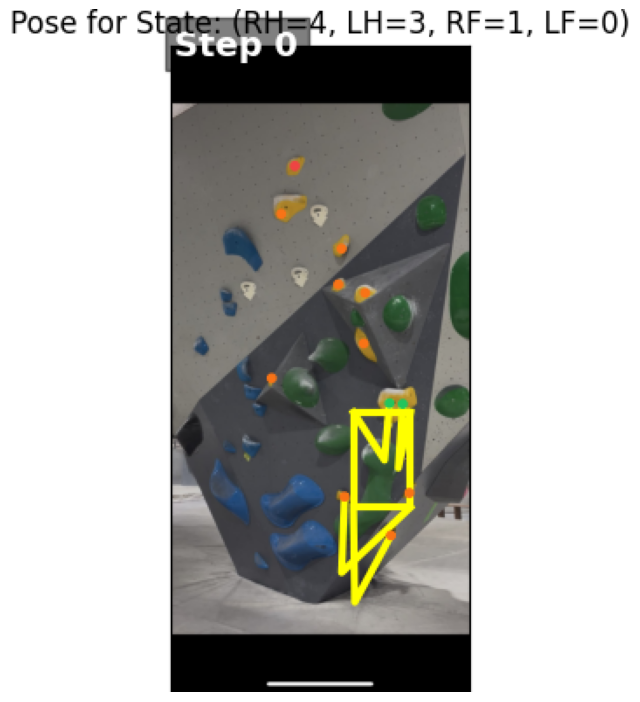

In [8]:
# Test with the first state in the sequence
if beta_sequence:
    first_state = beta_sequence[0]
    frame_path = create_beta_frame(IMAGE_PATH, route_data['holds'], first_state, 0)
    
    # Display the generated image directly in the notebook
    display_img = Image.open(frame_path)
    plt.figure(figsize=(8, 10))
    plt.imshow(display_img)
    plt.axis('off')
    plt.show()
else:
    print("Cannot generate frame, no path found.")

In [9]:
if beta_sequence and len(beta_sequence) > 1: # Also check if path has more than just the start
    # Use 'pt' as the unit and pass the image dimensions as the format size in points.
    pdf = FPDF(unit="pt", format=[IMAGE_WIDTH, IMAGE_HEIGHT])
    frame_files = []

    print("Generating frames for PDF...")
    for i, state in enumerate(beta_sequence):
        print(f"  - Creating frame for step {i}")
        frame_path = create_beta_frame(IMAGE_PATH, route_data['holds'], state, i)
        frame_files.append(frame_path)

        pdf.add_page()
        # The image will be scaled to fit the page defined in the format.
        pdf.image(frame_path, x=0, y=0, w=IMAGE_WIDTH, h=IMAGE_HEIGHT)

    # Save the PDF
    pdf_output_path = "climbing_beta_test.pdf"
    pdf.output(pdf_output_path)
    print(f"\n✅ PDF generated successfully: {pdf_output_path}")

    import os
    for file in frame_files:
        os.remove(file)
    print("Temporary image files removed.")
elif beta_sequence:
    print("❌ Cannot generate PDF: The path only contains the starting position. No moves were found.")
else:
    print("❌ Cannot generate PDF: No feasible path was found at all.")

Generating frames for PDF...
  - Creating frame for step 0
  - Creating frame for step 1
  - Creating frame for step 2
  - Creating frame for step 3
  - Creating frame for step 4
  - Creating frame for step 5
  - Creating frame for step 6
  - Creating frame for step 7
  - Creating frame for step 8

✅ PDF generated successfully: climbing_beta_test.pdf
Temporary image files removed.
